In [87]:
import random
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from itertools import permutations
from time import time

In [70]:
movies = pd.read_table('Data/MovieLens/movies.dat', header=None, sep='::', names=['movie_id', 'title', 'genres'], engine='python', encoding='latin-1')
movies['genres'] = movies['genres'].str.split('|').str[0]
ratings = pd.read_table('Data/MovieLens/ratings.dat', header=None, sep='::', names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python')
ratings = ratings.merge(movies, on='movie_id')
ratings['rating'] *= 1/5
rewards = ratings.groupby('genres')['rating'].agg(lambda x: list(x)).to_dict()

In [ ]:
class Bandit:
    def __init__(self, rewards, c, alpha, reference_point_alpha):
        self.arms = {arm: {'observed_rewards': [], 'observed_count': 0, 'empirical_mean': 0} for arm in rewards}
        self.rewards = rewards
        self.c = c
        self.alpha = alpha
        self.reference_point_alpha = reference_point_alpha
    
    def get_UCB(self, arms, round, reference_point=False):
        alpha = self.alpha if not reference_point else self.reference_point_alpha
        if len(arms) == 1:
            arm = arms[0]
            exploration_term = np.sqrt((alpha * np.log(round)) / self.arms[arm]['observed_count'])
            return self.arms[arm]['empirical_mean'] + exploration_term
        else:
            probed_arm = arms[0]
            backup_arm = arms[1]
            backup_exploration_term = np.sqrt((alpha * np.log(round)) / self.arms[backup_arm]['observed_count'])
            probed_exploration_term = np.sqrt((alpha * np.log(round)) / self.arms[probed_arm]['observed_count'])
            return np.sum([max(reward, self.arms[backup_arm]['empirical_mean'] + backup_exploration_term) for reward in self.arms[probed_arm]['observed_rewards']]) / self.arms[probed_arm]['observed_count'] - self.c + probed_exploration_term


    def update_arm(self, arm, reward):
        self.arms[arm]['observed_rewards'].append(reward)
        self.arms[arm]['observed_count'] += 1
        self.arms[arm]['empirical_mean'] = self.arms[arm]['empirical_mean'] * (self.arms[arm]['observed_count'] - 1) / self.arms[arm]['observed_count'] + reward / self.arms[arm]['observed_count'] if self.arms[arm]['observed_count'] > 1 else reward


    def pull(self, action, round):
        if len(action) == 1:
            arm = action[0]
            reward = random.choice(self.rewards[arm])
            self.update_arm(arm, reward)
            return reward
        probed_arm = action[0]
        backup_arm = action[1]
        probed_reward = random.choice(self.rewards[probed_arm])
        self.update_arm(probed_arm, probed_reward - self.c)
        if probed_reward > self.get_UCB((backup_arm,), round, True):
            return probed_reward - self.c
        backup_reward = random.choice(self.rewards[backup_arm])
        self.update_arm(backup_arm, backup_reward - self.c)
        return backup_reward - self.c
    
    def calculate_optimal_value(self):
        means = sorted([(arm, np.mean(self.rewards[arm])) for arm in self.rewards], key=lambda x: x[1], reverse=True)
        probes = [np.mean([max(reward, means[0][1]) for reward in self.rewards[arm]]) - self.c for arm in self.rewards] + [np.mean([max(reward, means[1][1]) for reward in self.rewards[means[0][0]]]) - self.c, means[0][1]]
        return max(probes)
        
    def reset(self, c=None, alpha=None, reference_point_alpha=None):
        self.arms = {arm: {'observed_rewards': [], 'observed_count': 0, 'empirical_mean': 0} for arm in self.rewards}
        if c:
            self.c = c
        if alpha:
            self.alpha = alpha
        if reference_point_alpha:
            self.reference_point_alpha = reference_point_alpha

    def run(self, T):
        regret = []
        optimal_value = self.calculate_optimal_value()
        probe_actions = list(permutations(list(self.arms), 2))
        pull_actions = [(arm, ) for arm in self.arms]
        for action in pull_actions:
            self.pull(action, 0)
        total_reward = 0
        for round in tqdm.tqdm(range(1, T+1)):
            action = max(probe_actions + pull_actions, key=lambda action: self.get_UCB(action, round))
            reward = self.pull(action, round)
            total_reward += reward
            regret.append(round*optimal_value - total_reward)
        return regret



bandit = Bandit(rewards, 0, 3, 27)
regret = {}
for c in [0, 0.075, 0.25, 0.5, 1]:
    bandit.reset(c=c)
    regret[c] = bandit.run(3000)

100%|██████████| 3000/3000 [01:02<00:00, 48.11it/s]


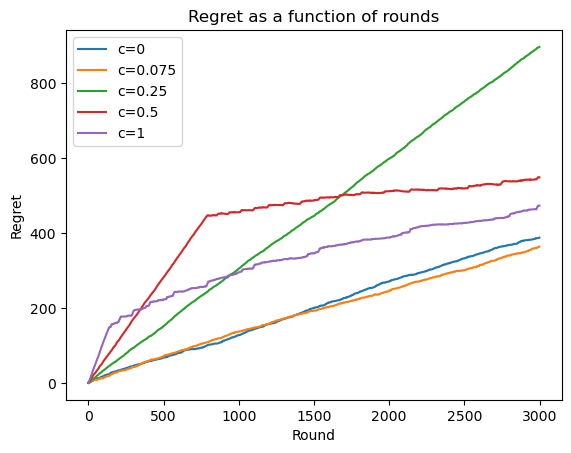

In [94]:
for c in regret:
    plt.plot(regret[c], label=f'c={c}')
    plt.legend()
    plt.xlabel('Round')
    plt.ylabel('Regret')
    plt.title('Regret as a function of rounds')
plt.show()